In [40]:
import numpy as np

# matpllitb
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import random

In [41]:
class ACSIncomeSplit:
    def split_indexes_iid(num_clients, num_samples):
        indexes = np.arange(num_samples)
        np.random.shuffle(indexes)
        return np.array_split(indexes, num_clients)

    def split_indexes_non_iid(labels_and_grops_indexes, num_clients, alpha):
        labels = []
        groups = []
        indexes = {}
        for label, group, _ in labels_and_grops_indexes:
            labels.append(label)
            groups.append(group)

        label_and_group = list(zip(labels, groups))
        for index, (label, group) in enumerate(label_and_group):
            if (label, group) not in indexes:
                indexes[(label, group)] = []
            indexes[(label, group)].append(index)

        possible_labels_and_groups = list(set(label_and_group))
        # generate len(possible_labels_and_groups) dirichlet distributions with alpha
        # we need a distribution for each possible (label, group) and for each distribution
        # we need to have a probability for each client
        distributions = []
        for partition in range(len(possible_labels_and_groups)):
            distribution = np.random.dirichlet(num_clients * [alpha], size=1)
            distributions.append(distribution[0])

        # now we sample from each of the distributions to get the indexes for each client
        # we do not want to sample the same index twice
        clients_indexes = []
        for client in range(num_clients):
            client_indexes = []
            for partition in range(len(possible_labels_and_groups)):
                indexes_for_partition = indexes[possible_labels_and_groups[partition]]
                num_samples = int(
                    distributions[partition][client] * len(indexes_for_partition)
                )
                samples = np.random.choice(
                    indexes_for_partition, num_samples, replace=False
                )
                client_indexes.extend(samples)
            clients_indexes.append(client_indexes)

        return clients_indexes


class TabularDataset(Dataset):
    def __init__(self, x, z, y):
        """
        Initialize the custom dataset with x (features), z (sensitive values), and y (targets).

        Args:
        x (list of tensors): List of input feature tensors.
        z (list): List of sensitive values.
        y (list): List of target values.
        """
        self.samples = x
        self.sensitive_features = z
        self.sensitive_attribute = z
        self.gender = z
        self.classes = y
        self.targets = y

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a single data point from the dataset.

        Args:
        idx (int): Index to retrieve the data point.

        Returns:
        sample (dict): A dictionary containing 'x', 'z', and 'y'.
        """
        x_sample = self.samples[idx]
        z_sample = self.sensitive_features[idx]
        y_sample = self.targets[idx]

        return x_sample, z_sample, y_sample

In [47]:
num_clusters = 51
max_len_public = 0.5
num_clients = 5

test_size = 0.2
validation_size = 0.2

random.seed(42)

public_private_indexes = []
public_private_indexes_validation = []

clusters_test_data = []

for cluster in range(num_clusters):
    dataframe = np.load(
        f"./data/income/federated/{cluster}/income_dataframes_{cluster}.npy"
    )
    income_groups = np.load(
        f"./data/income/federated/{cluster}/income_groups_{cluster}.npy"
    )
    income_labels = np.load(
        f"./data/income/federated/{cluster}/income_labels_{cluster}.npy"
    )

    # sample from a numpy array

    test_indexes = np.arange(len(dataframe))
    num_samples_test = int(len(dataframe) * test_size)
    sampled_indexes_test = np.random.choice(
        test_indexes, num_samples_test, replace=False
    )

    dataframe_test = dataframe[sampled_indexes_test]
    income_groups_test = income_groups[sampled_indexes_test]
    income_labels_test = income_labels[sampled_indexes_test]

    cluster_test_data = TabularDataset(
        dataframe_test, income_groups_test, income_labels_test
    )
    clusters_test_data.append((dataframe_test, income_groups_test, income_labels_test))
    torch.save(
        cluster_test_data, f"./data/income/federated_data/test_cluster_{cluster}.pt"
    )

    # remove the sampled_indexes_test from the original numpy array
    dataframe = np.delete(dataframe, sampled_indexes_test, axis=0)
    income_groups = np.delete(income_groups, sampled_indexes_test)
    income_labels = np.delete(income_labels, sampled_indexes_test)

    dataset_test = TabularDataset(
        dataframe_test, income_groups_test, income_labels_test
    )

    labels_and_groups_indexes = [
        (lab, group, index)
        for lab, group, index in zip(
            list(income_labels),
            list(income_groups),
            range(len(income_labels)),
        )
    ]

    client_indexes = ACSIncomeSplit.split_indexes_non_iid(
        labels_and_groups_indexes, num_clients=num_clients, alpha=5
    )
    labels_and_group_indexes_public_private = []
    # for each client we get the labels and the groups because we need to
    # create the public and private datasets
    for client in client_indexes:
        label = income_labels[client]
        group = income_groups[client]
        index = client
        labels_and_group_indexes_public_private.append(
            [(lab, group, ind) for lab, group, ind in zip(label, group, index)]
        )

    tmp_public_private_indexes = []
    tmp_public_private_indexes_validation = []
    for client_id, client in enumerate(labels_and_group_indexes_public_private):
        total_size_data = len(client)
        indexes = [index for (label, group, index) in client]
        public_size_data = int(total_size_data * max_len_public)
        private_size_data = total_size_data - public_size_data
        # random sample public_size_data samples from the indexes of the client
        # based on a dirichlet distribution
        distribution = np.random.dirichlet(private_size_data * [1], size=1)
        # private_indexes = np.random.choice(
        #     indexes, private_size_data, replace=False, p=distribution[0]
        # )
        private_indexes = np.random.choice(indexes, private_size_data, replace=False)
        private_indexes_validation = np.random.choice(
            private_indexes, int(private_size_data * validation_size), replace=False
        )
        private_indexes = [index for index in indexes if index not in private_indexes]

        private_data = dataframe[private_indexes]
        private_groups = income_groups[private_indexes]
        private_labels = income_labels[private_indexes]
        private_data_validation = dataframe[private_indexes_validation]
        private_groups_validation = income_groups[private_indexes_validation]
        private_labels_validation = income_labels[private_indexes_validation]

        private_dataset = TabularDataset(private_data, private_groups, private_labels)
        private_dataset_validation = TabularDataset(
            private_data_validation,
            private_groups_validation,
            private_labels_validation,
        )

        torch.save(
            private_dataset,
            f"./data/income/federated_data/cluster_{cluster}_node_{client_id}_private_train.pt",
        )
        torch.save(
            private_dataset_validation,
            f"./data/income/federated_data/cluster_{cluster}_node_{client_id}_private_validation.pt",
        )

        public_indexes = [index for index in indexes if index not in private_indexes]
        public_indexes_validation = np.random.choice(
            public_indexes, int(public_size_data * validation_size), replace=False
        )
        public_indexes = [index for index in indexes if index not in public_indexes]

        public_data = dataframe[public_indexes]
        public_groups = income_groups[public_indexes]
        public_labels = income_labels[public_indexes]
        public_data_validation = dataframe[public_indexes_validation]
        public_groups_validation = income_groups[public_indexes_validation]
        public_labels_validation = income_labels[public_indexes_validation]

        public_dataset = TabularDataset(public_data, public_groups, public_labels)
        public_dataset_validation = TabularDataset(
            public_data_validation, public_groups_validation, public_labels_validation
        )

        torch.save(
            public_dataset,
            f"./data/income/federated_data/cluster_{cluster}_node_{client_id}_public_train.pt",
        )
        torch.save(
            public_dataset_validation,
            f"./data/income/federated_data/cluster_{cluster}_node_{client_id}_public_validation.pt",
        )

        tmp_public_private_indexes.append((public_indexes, private_indexes))
        tmp_public_private_indexes_validation.append(
            (public_indexes_validation, private_indexes_validation)
        )

    public_private_indexes.append(tmp_public_private_indexes)
    public_private_indexes_validation.append(tmp_public_private_indexes_validation)


data = [data for (data, _, _) in clusters_test_data]
# concatenate the numpy arrays
data = np.concatenate(data, axis=0)
groups = [groups for (_, groups, _) in clusters_test_data]
groups = np.concatenate(groups, axis=0)
labels = [labels for (_, _, labels) in clusters_test_data]
labels = np.concatenate(labels, axis=0)

test_dataset = TabularDataset(data, groups, labels)
torch.save(test_dataset, "./data/income/federated_data/server_test_set.pt")

In [23]:
for cluster_id, cluster in enumerate(public_private_indexes):
    for client_id, client in enumerate(cluster):
        dataframe = np.load(
            f"./data/income/federated/{cluster_id}/income_dataframes_{cluster_id}.npy"
        )
        income_groups = np.load(
            f"./data/income/federated/{cluster_id}/income_groups_{cluster_id}.npy"
        )
        income_labels = np.load(
            f"./data/income/federated/{cluster_id}/income_labels_{cluster_id}.npy"
        )

        public_indexes, private_indexes = client
        public_data = dataframe[public_indexes]
        private_data = dataframe[private_indexes]
        public_groups = income_groups[public_indexes]
        private_groups = income_groups[private_indexes]
        public_labels = income_labels[public_indexes]
        private_labels = income_labels[private_indexes]
        public_dataset = TabularDataset(public_data, public_groups, public_labels)
        private_dataset = TabularDataset(private_data, private_groups, private_labels)

        torch.save(
            public_dataset,
            f"./data/income/federated/{cluster_id}/public_dataset_{client_id}.pt",
        )
        torch.save(
            private_dataset,
            f"./data/income/federated/{cluster_id}/private_dataset_{client_id}.pt",
        )

In [3]:
# load data
dataframe = np.load("./data/income/federated/0/income_dataframes_0.npy")
income_groups = np.load("./data/income/federated/0/income_groups_0.npy")
income_labels = np.load("./data/income/federated/0/income_labels_0.npy")
max_len_public = 0.2
labels_and_groups = [
    (lab, group) for lab, group in zip(list(income_labels), list(income_groups))
]
labels_and_groups_indexes = [
    (lab, group, index)
    for lab, group, index in zip(
        list(income_labels), list(income_groups), range(len(income_labels))
    )
]

In [4]:
split_iid = ACSIncomeSplit.split_indexes_iid(10, len(dataframe))
# split the data, labels and groups into 10 clients using the indexes from split_iid
dataframe_splits_private = [
    dataframe[split_iid[i][0 : int(max_len_public * len(split_iid[i]))]]
    for i in range(len(split_iid))
]
labels_splits_private = [
    income_labels[split_iid[i][0 : int(max_len_public * len(split_iid[i]))]]
    for i in range(len(split_iid))
]
groups_splits_private = [
    income_groups[split_iid[i][0 : int(max_len_public * len(split_iid[i]))]]
    for i in range(len(split_iid))
]

dataframe_splits_public = [
    dataframe[split_iid[i][int(max_len_public * len(split_iid[i])) :]]
    for i in range(len(split_iid))
]
labels_splits_public = [
    income_labels[split_iid[i][int(max_len_public * len(split_iid[i])) :]]
    for i in range(len(split_iid))
]
groups_splits_public = [
    income_groups[split_iid[i][int(max_len_public * len(split_iid[i])) :]]
    for i in range(len(split_iid))
]

In [6]:
clients_indexes = ACSIncomeSplit.split_indexes_non_iid(labels_and_groups_indexes, 10, 5)
# plot a bar plot of the amount of (labels, groups) for each client
# using a bar plot and matplotlib. On x axis I want the clients
# and on the y axis I want the amount of (labels, groups) for each client

from collections import Counter

labels_groups_per_clients = []
labels = np.array(income_labels)
groups = np.array(income_groups)
counters = []
for client_index in clients_indexes:
    labels_groups_per_clients.append(
        [(lab, group) for lab, group in zip(labels[client_index], groups[client_index])]
    )
    counters.append(Counter(labels_groups_per_clients[-1]))

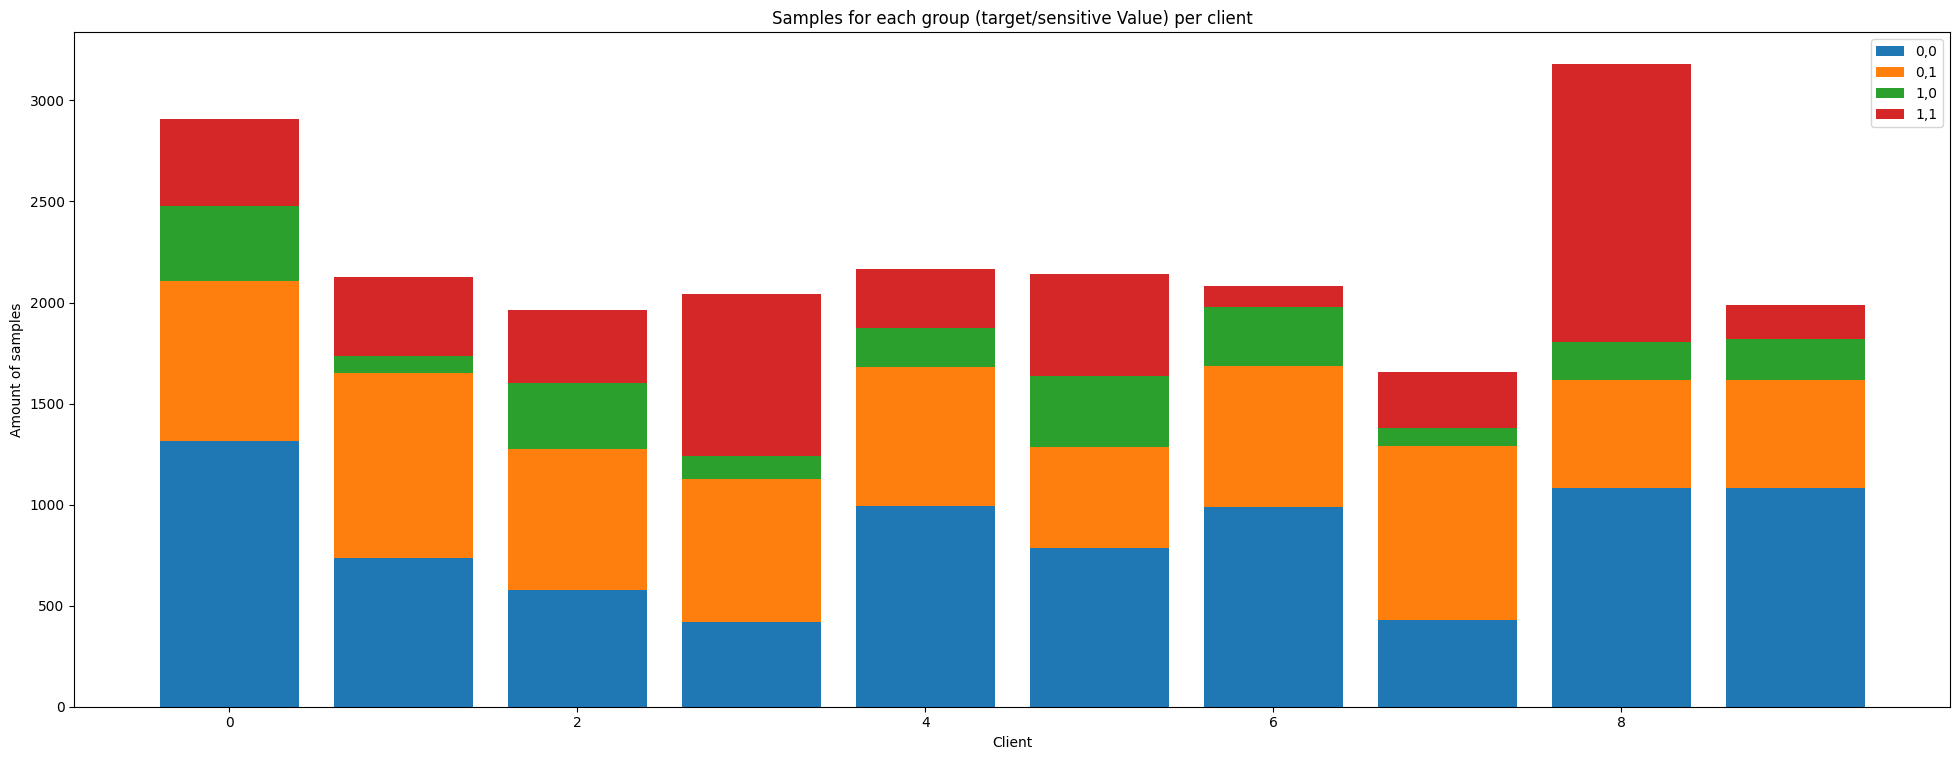

In [8]:
counter_group_0_0 = [counter[(0, 0)] for counter in counters]
counter_group_0_1 = [counter[(0, 1)] for counter in counters]
counter_group_1_0 = [counter[(1, 0)] for counter in counters]
counter_group_1_1 = [counter[(1, 1)] for counter in counters]

# plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
# for each client in the same plot
plt.figure(figsize=(20, 8))

plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
plt.bar(
    range(len(counter_group_1_0)),
    counter_group_1_0,
    bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)],
)
plt.bar(
    range(len(counter_group_1_1)),
    counter_group_1_1,
    bottom=[
        sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)
    ],
)


plt.xlabel("Client")
plt.ylabel("Amount of samples")
plt.title("Samples for each group (target/sensitive Value) per client")
plt.legend(["0,0", "0,1", "1,0", "1,1"])
# font size 20
plt.rcParams.update({"font.size": 20})
plt.tight_layout()

In [9]:
labels_and_group_indexes_public_private = []
for client in clients_indexes:
    label = income_labels[client]
    group = income_groups[client]
    index = client
    labels_and_group_indexes_public_private.append(
        [(lab, group, ind) for lab, group, ind in zip(label, group, index)]
    )

In [10]:
public_size = 0.8

In [11]:
public_private_indexes = []
for client in labels_and_group_indexes_public_private:
    total_size_data = len(client)
    indexes = [index for (label, group, index) in client]
    public_size_data = int(total_size_data * public_size)
    private_size_data = total_size_data - public_size_data
    # random sample public_size_data samples from the indexes of the client
    # based on a dirichlet distribution
    distribution = np.random.dirichlet(private_size_data * [1], size=1)
    # private_indexes = np.random.choice(
    #     indexes, private_size_data, replace=False, p=distribution[0]
    # )
    private_indexes = np.random.choice(indexes, private_size_data, replace=False)
    public_indexes = [index for index in indexes if index not in private_indexes]

    public_private_indexes.append((public_indexes, private_indexes))

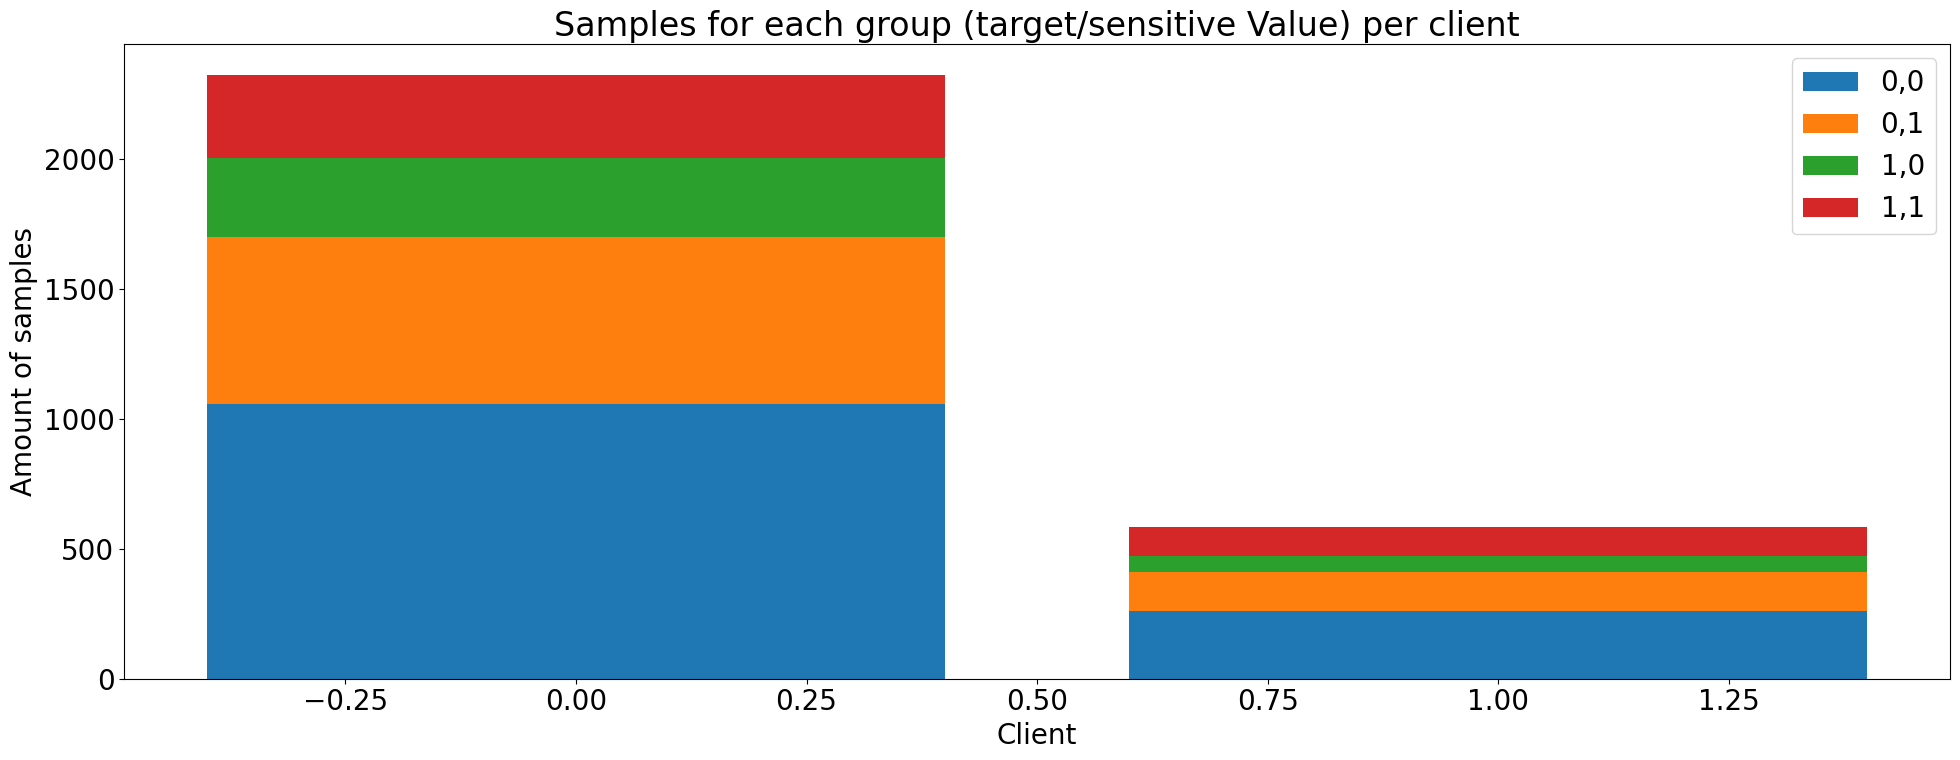

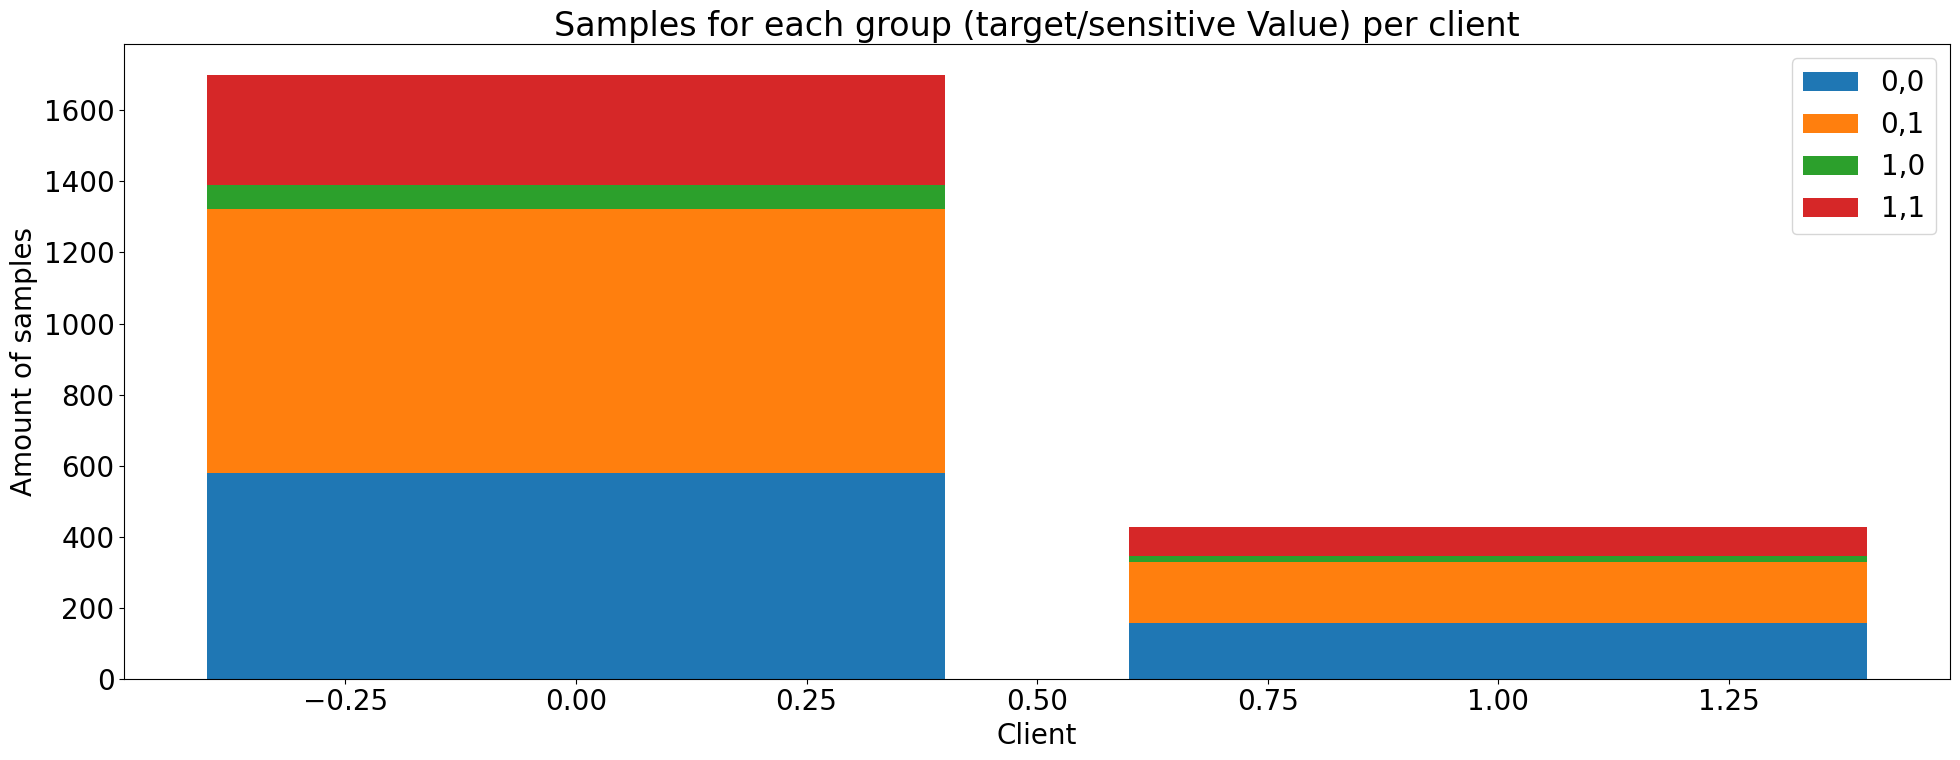

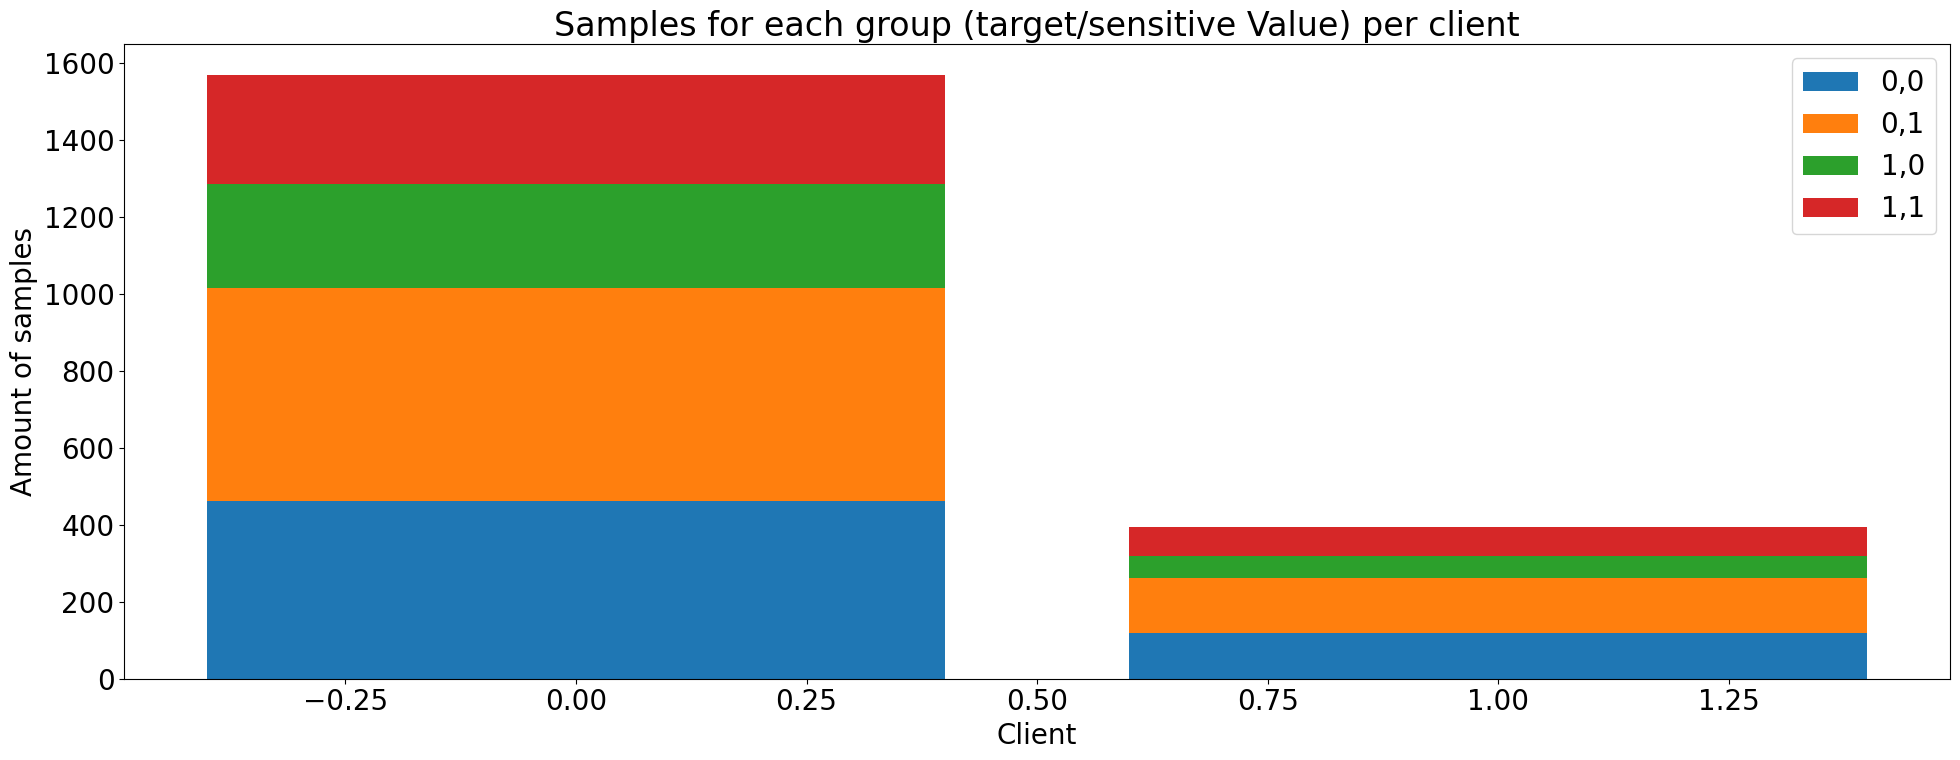

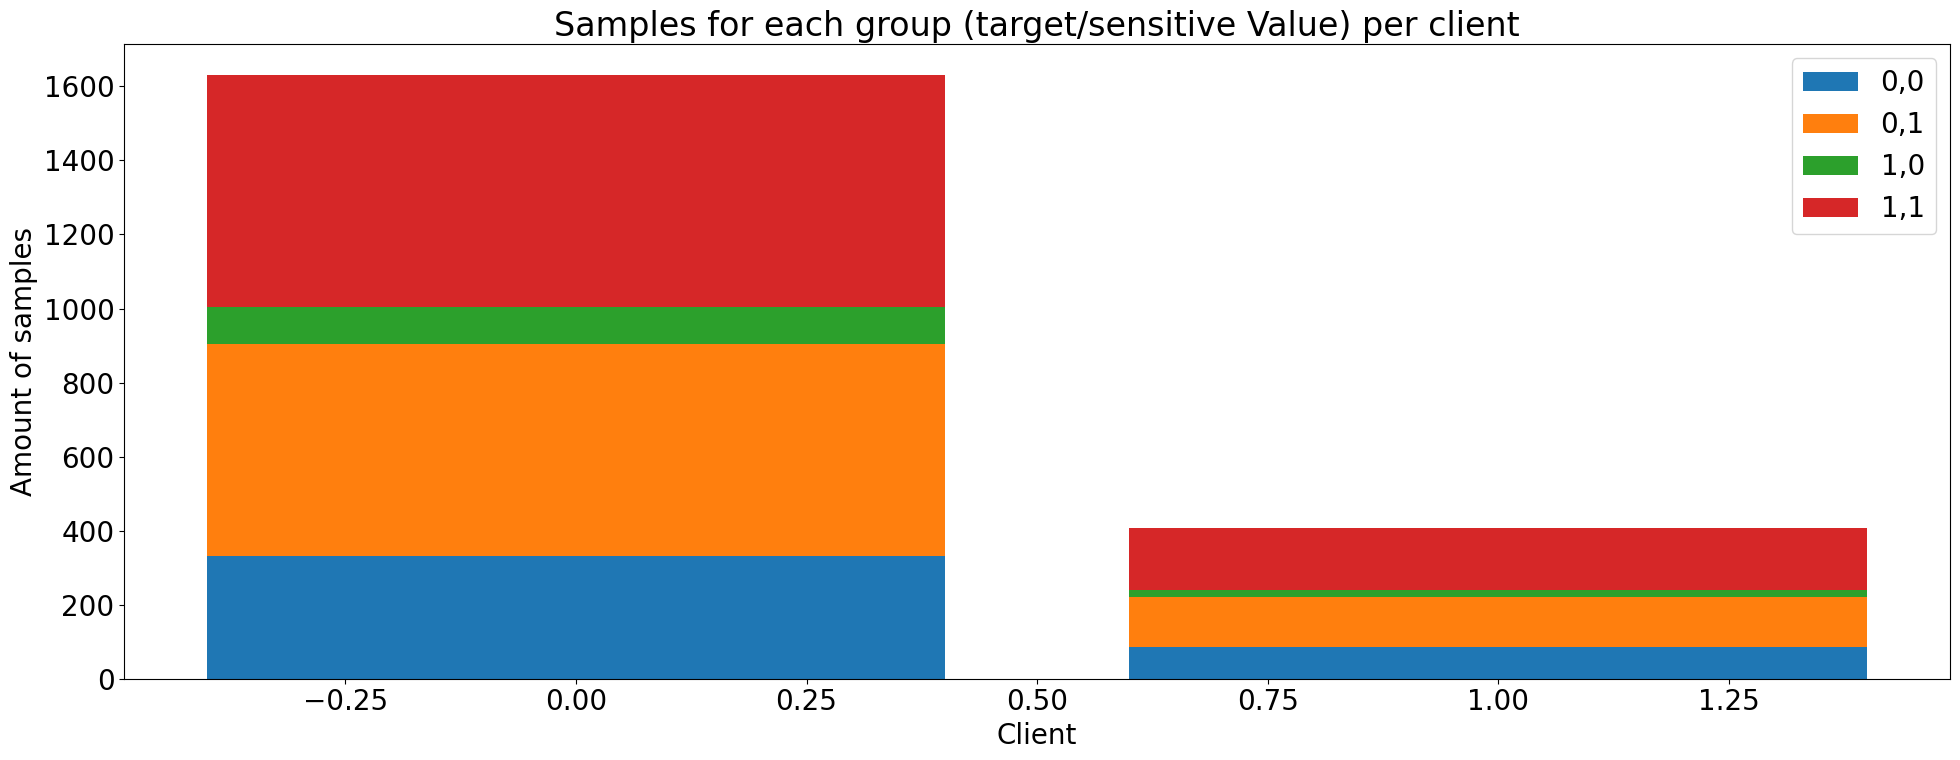

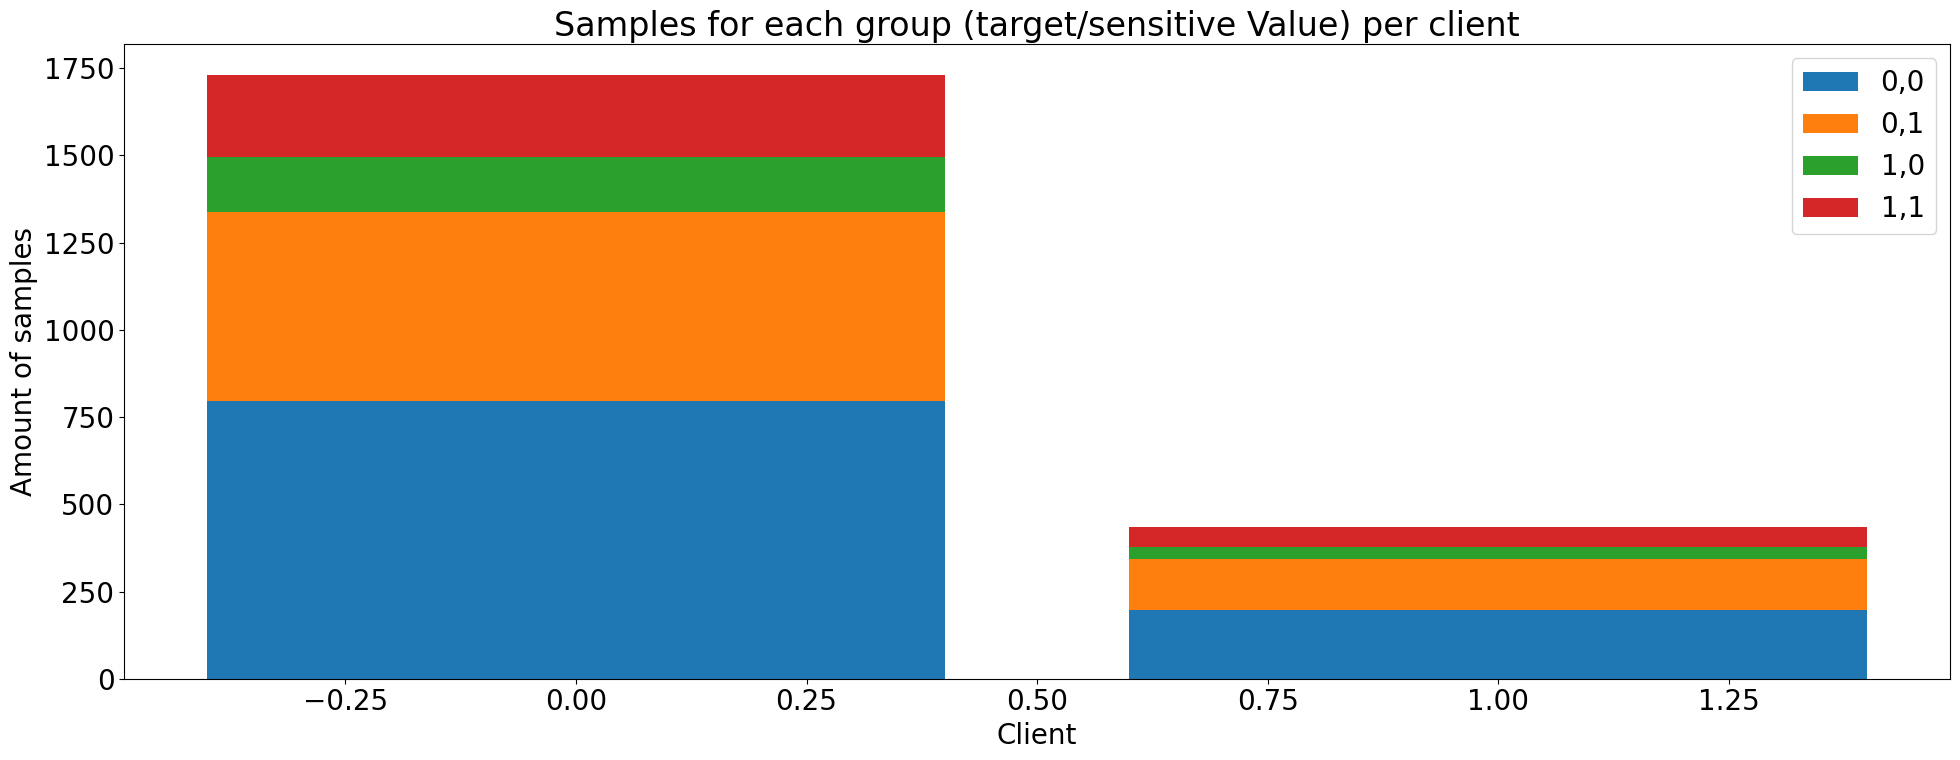

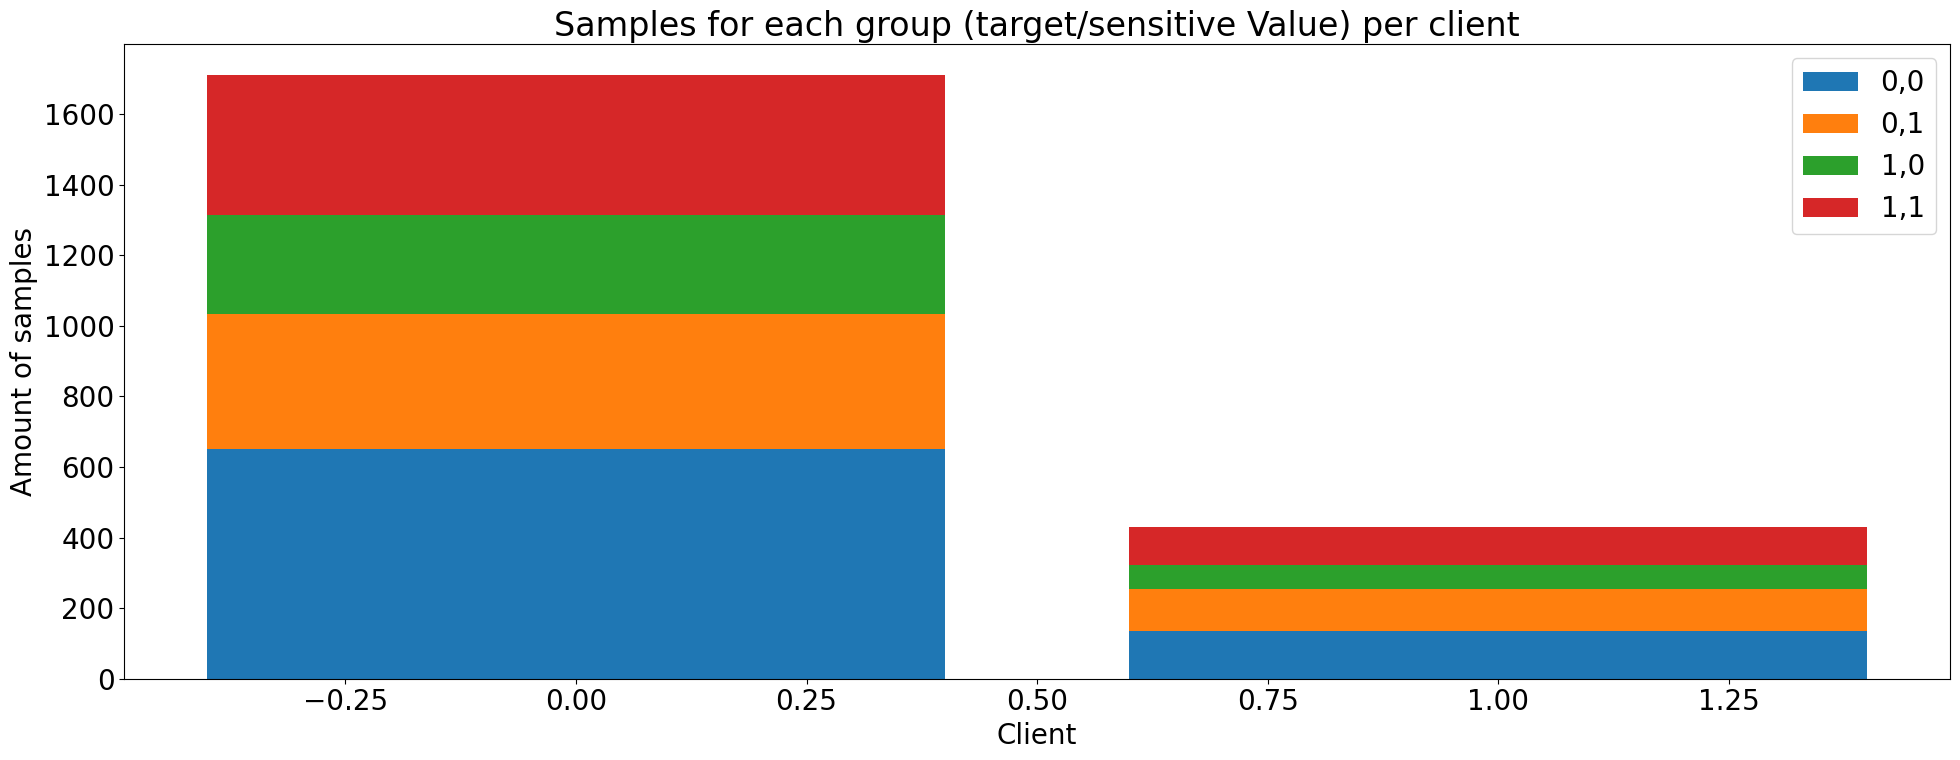

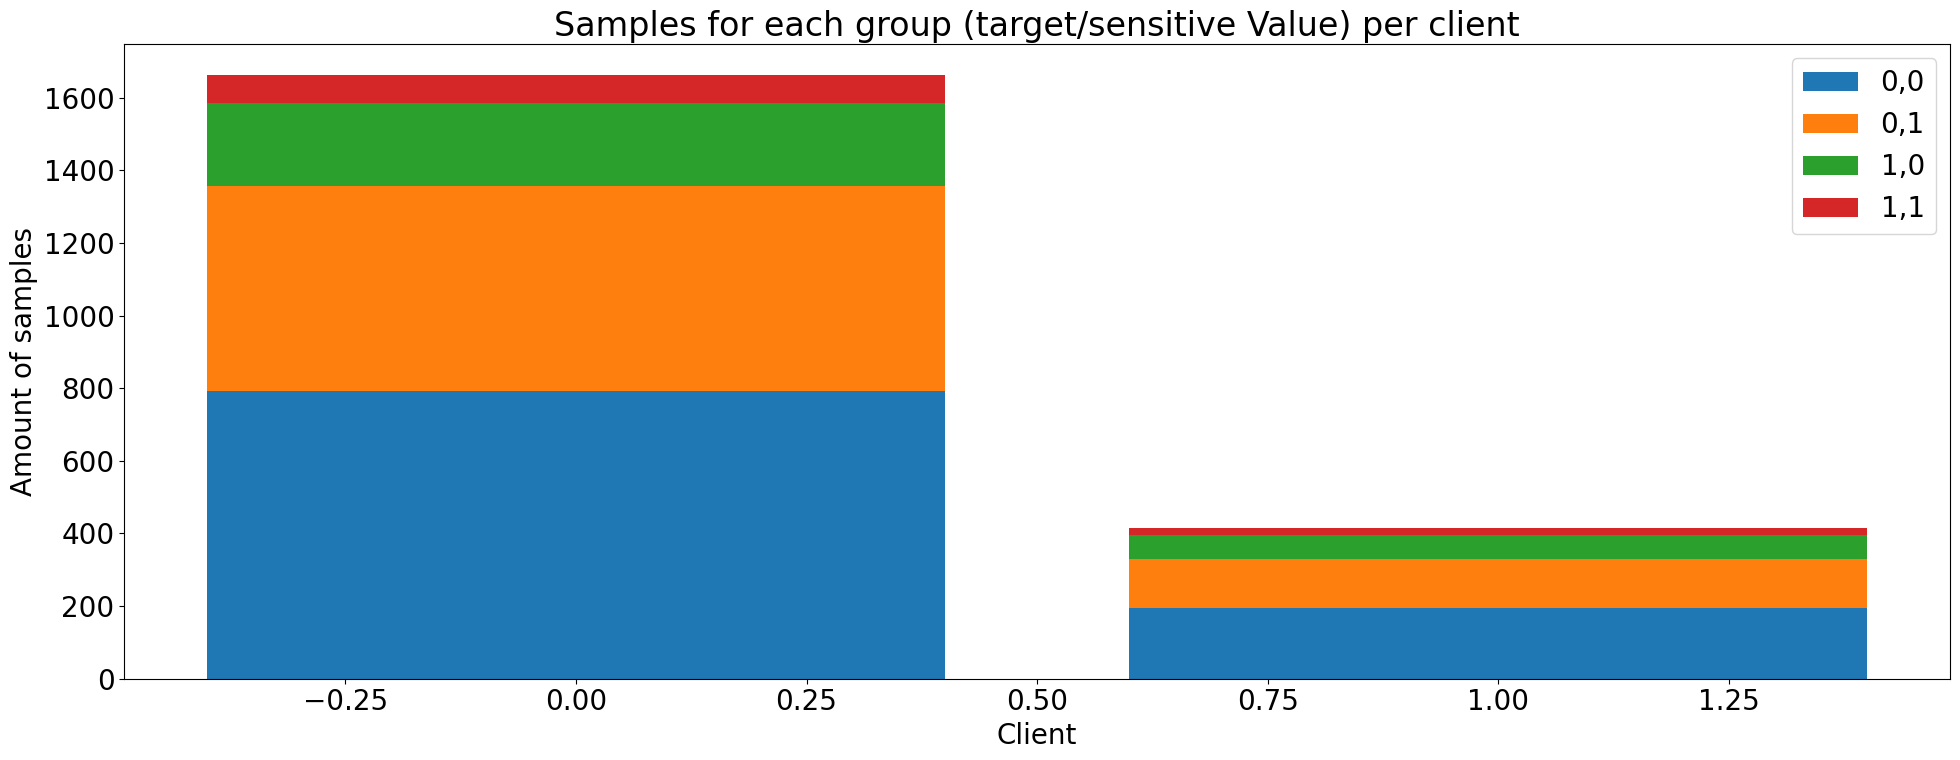

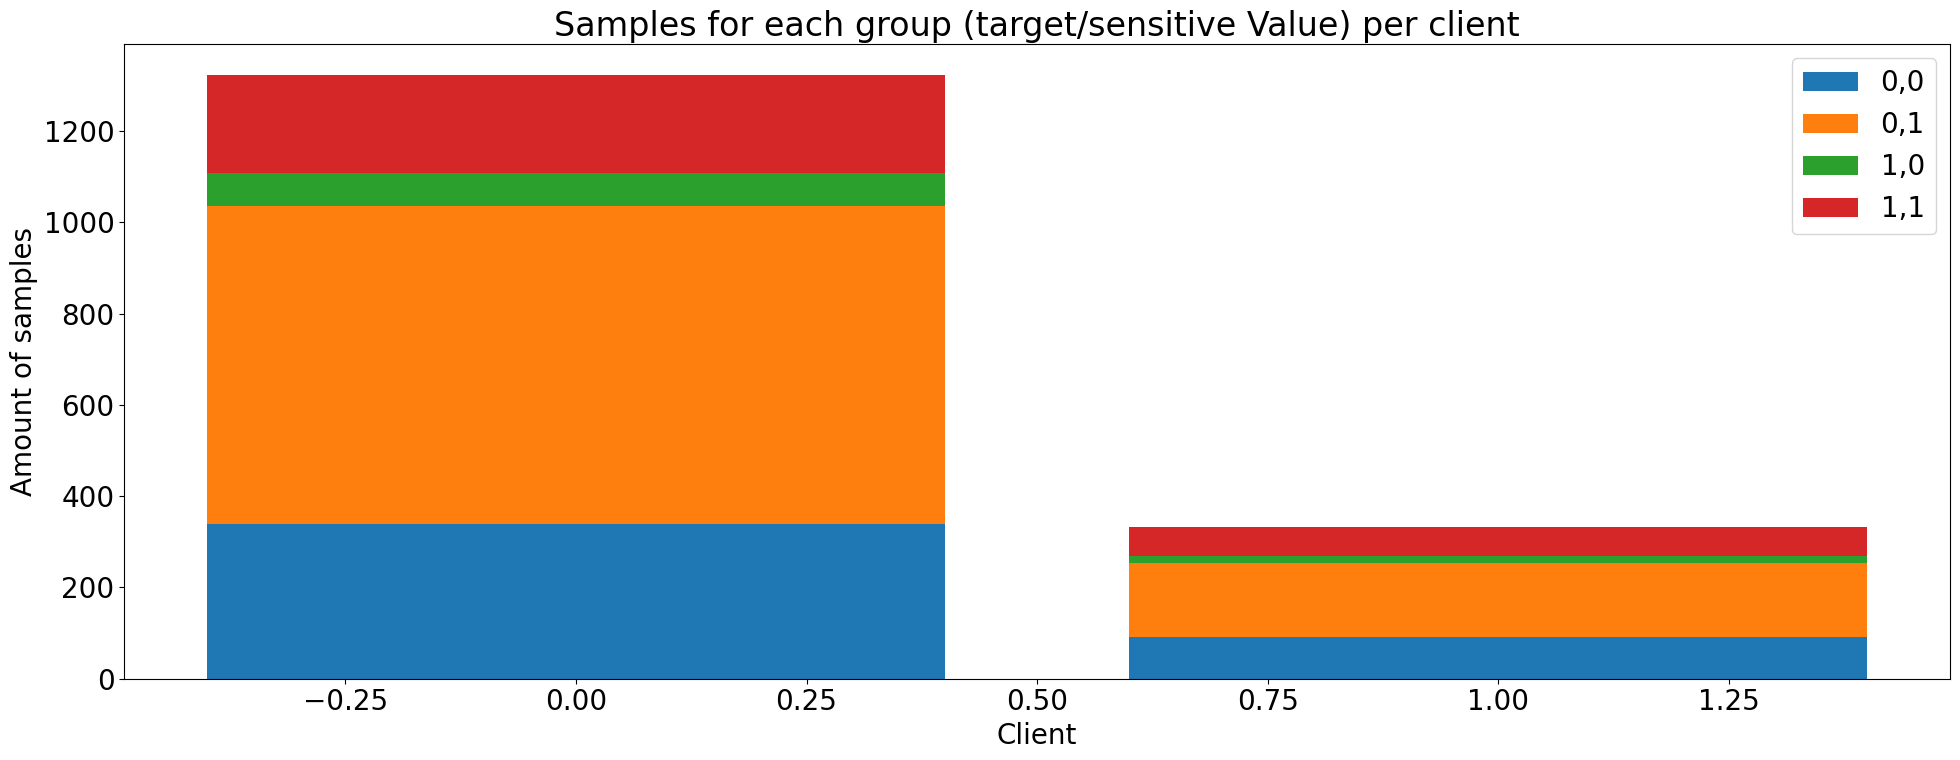

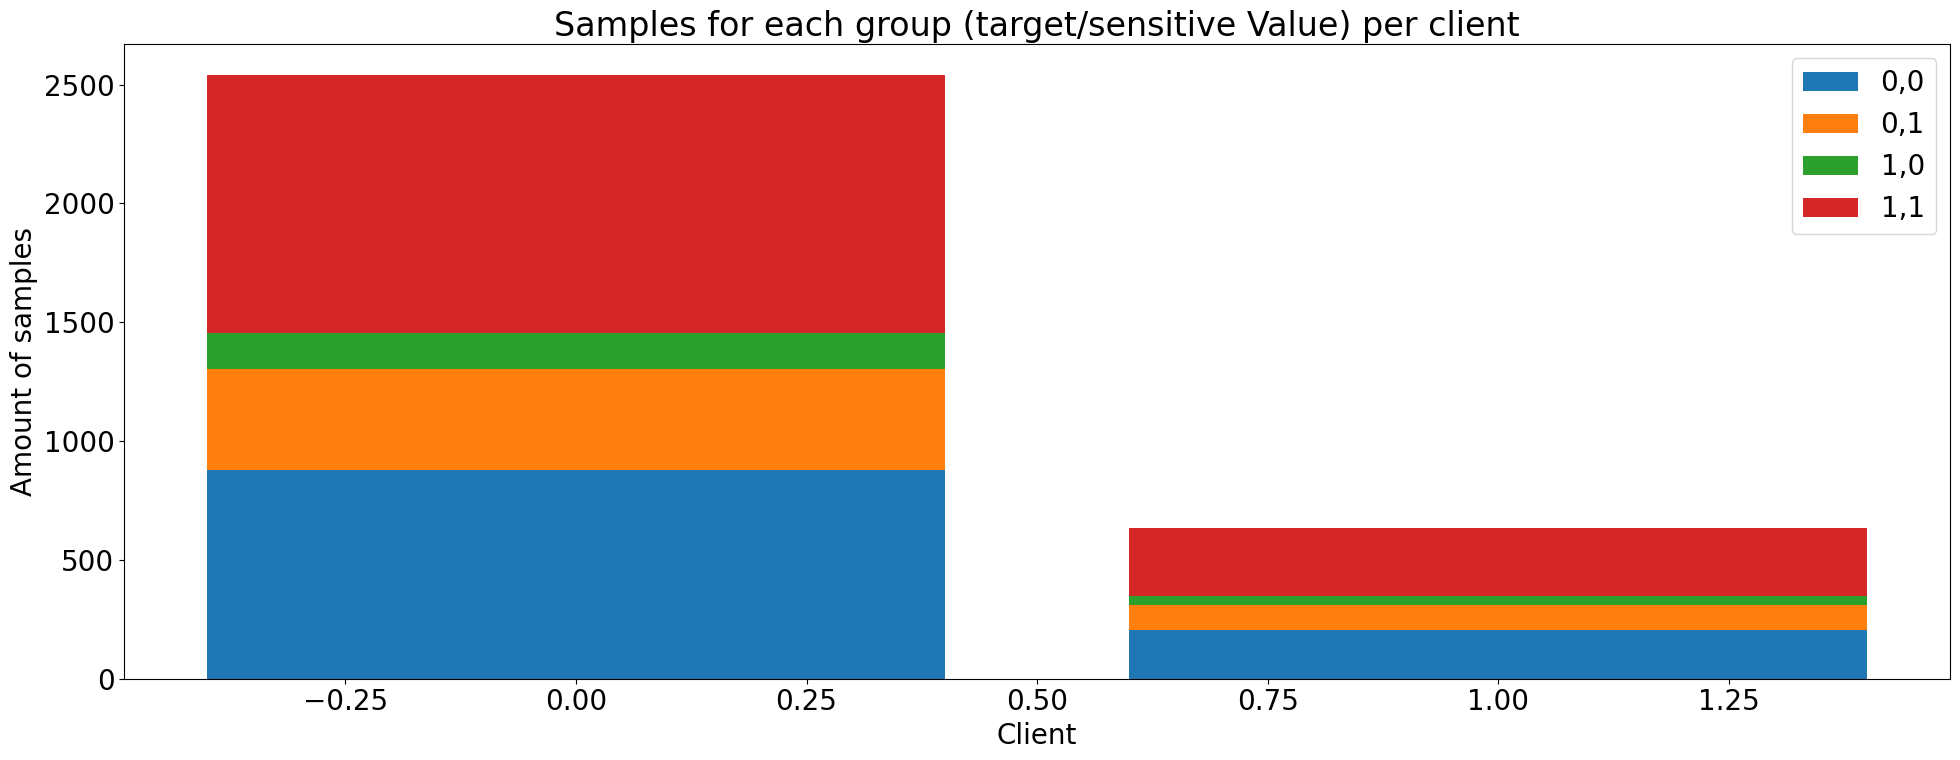

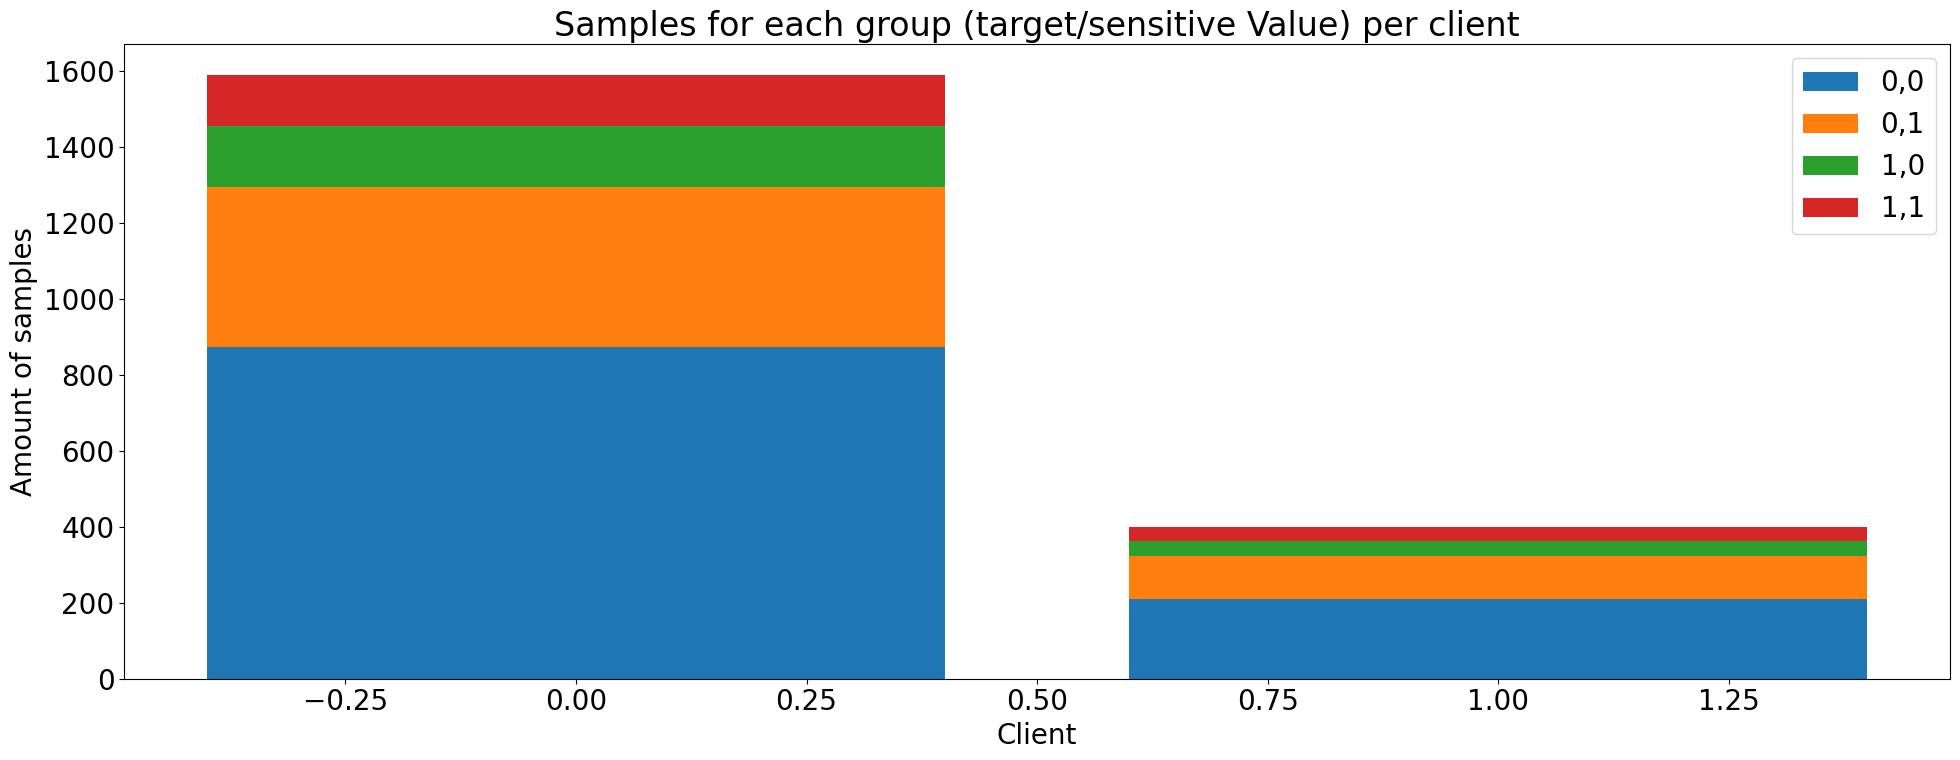

In [12]:
for public, private in public_private_indexes:
    labels_groups_per_clients = []
    labels = np.array(income_labels)
    groups = np.array(income_groups)
    counters = []

    labels_groups_per_clients.append(
        [(lab, group) for lab, group in zip(labels[public], groups[public])]
    )
    counters.append(Counter(labels_groups_per_clients[-1]))

    labels_groups_per_clients.append(
        [(lab, group) for lab, group in zip(labels[private], groups[private])]
    )
    counters.append(Counter(labels_groups_per_clients[-1]))

    counter_group_0_0 = [counter[(0, 0)] for counter in counters]
    counter_group_0_1 = [counter[(0, 1)] for counter in counters]
    counter_group_1_0 = [counter[(1, 0)] for counter in counters]
    counter_group_1_1 = [counter[(1, 1)] for counter in counters]

    # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
    # for each client in the same plot
    plt.figure(figsize=(20, 8))

    plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
    plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
    plt.bar(
        range(len(counter_group_1_0)),
        counter_group_1_0,
        bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)],
    )
    plt.bar(
        range(len(counter_group_1_1)),
        counter_group_1_1,
        bottom=[
            sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)
        ],
    )

    plt.xlabel("Client")
    plt.ylabel("Amount of samples")
    plt.title("Samples for each group (target/sensitive Value) per client")
    plt.legend(["0,0", "0,1", "1,0", "1,1"])
    # font size 20
    plt.rcParams.update({"font.size": 20})
    plt.tight_layout()

[[385, 111, 532, 762, 528, 439, 222, 408, 491, 65, 843, 709, 787, 774, 200, 282, 54, 495, 66, 21, 77, 269, 23, 596, 284, 526, 176, 501, 626, 367, 478, 750, 115, 295, 354, 72, 463, 127, 509, 763, 414, 820, 458, 656, 751, 484, 633, 393, 137, 344, 758, 467, 781, 294, 729, 443, 740, 120, 577, 173, 619, 18, 618, 103, 246, 546, 189, 44, 264, 479, 674, 270, 38, 649, 307, 824, 813, 102, 340, 98, 663, 78, 348, 30, 586, 52, 40, 790, 356, 305, 16, 394, 368, 278, 218, 33, 625, 250, 585, 1, 318, 516, 492, 753, 800, 400, 675, 570, 187, 235, 589, 412, 49, 113, 376, 337, 402, 320, 170, 485, 121, 68, 592, 338, 558, 474, 227, 242, 451, 737, 728, 576, 595, 834, 426, 634, 135, 803, 409, 442, 420, 765, 228, 190, 706, 788, 6, 693, 415, 413, 777, 214, 164, 818, 538, 494, 236, 801, 365, 205, 556, 274, 612, 683, 83, 434, 421, 545, 244, 224, 422, 691, 391, 448, 811, 10, 37, 469, 835, 563, 301, 718, 761, 194, 531, 471, 347, 704, 436, 174, 696, 311, 361, 141, 797, 34, 739, 840, 640, 67, 593, 172, 510, 602, 603, 5

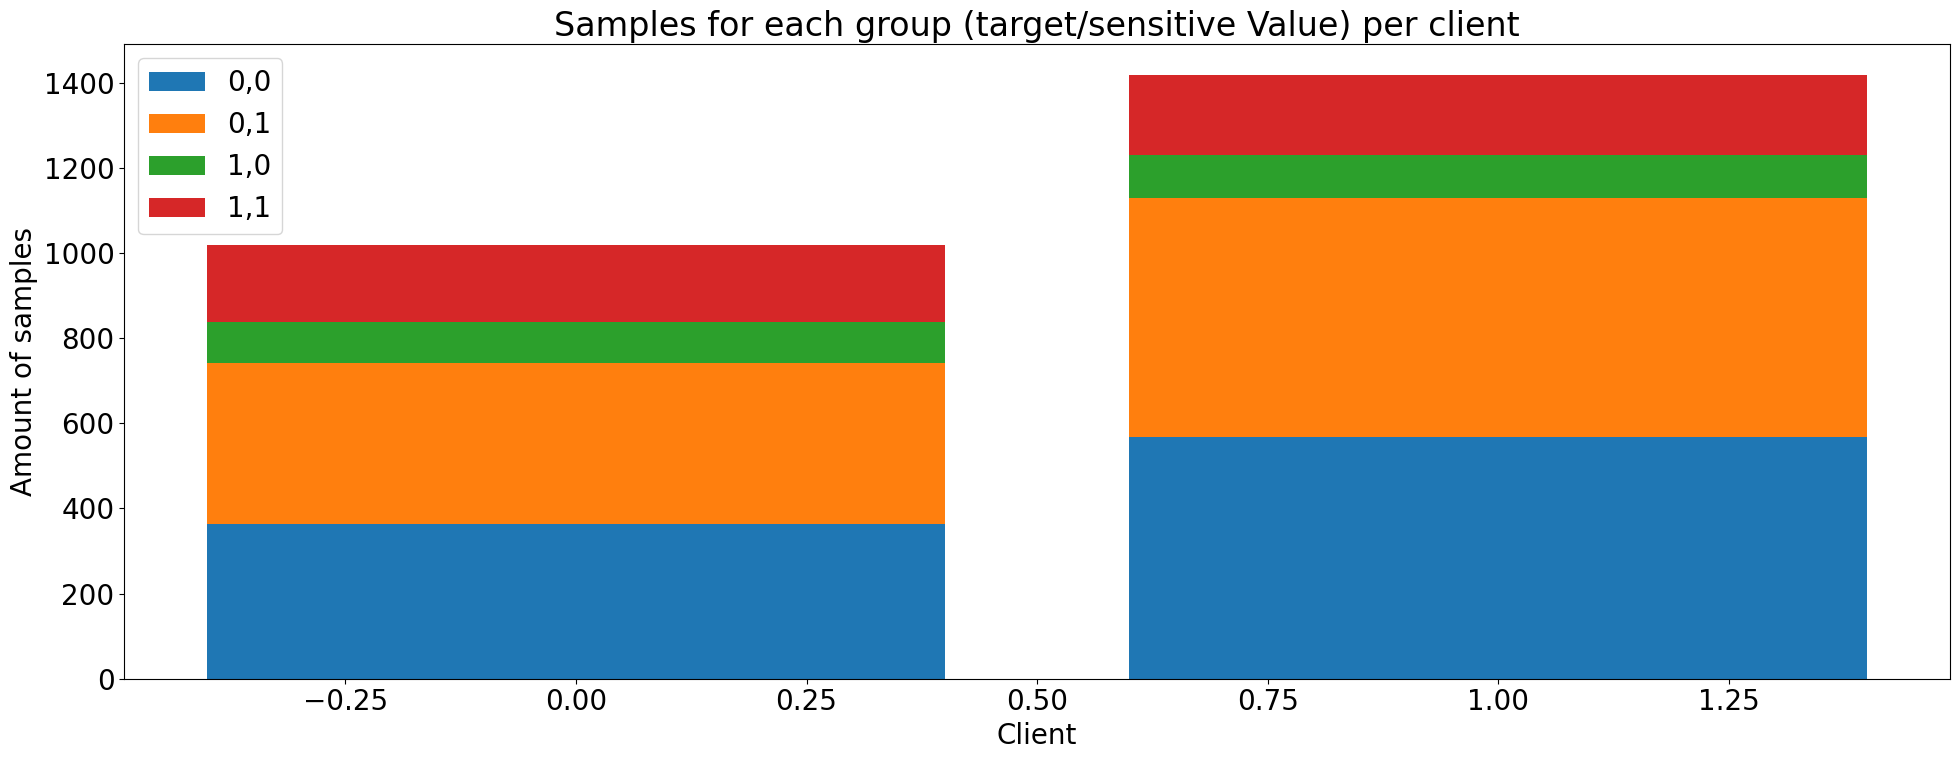

In [59]:
# clients_indexes = split_indexes_non_iid(
#     labels_and_group_indexes_public_private[0], 2, 5
# )
# print(clients_indexes)

# labels_groups_per_clients = []
# labels = np.array(income_labels)
# groups = np.array(income_groups)
# counters = []
# for client_index in clients_indexes:
#     labels_groups_per_clients.append(
#         [(lab, group) for lab, group in zip(labels[client_index], groups[client_index])]
#     )
#     counters.append(Counter(labels_groups_per_clients[-1]))


# print(len(labels_groups_per_clients))

# counter_group_0_0 = [counter[(0, 0)] for counter in counters]
# counter_group_0_1 = [counter[(0, 1)] for counter in counters]
# counter_group_1_0 = [counter[(1, 0)] for counter in counters]
# counter_group_1_1 = [counter[(1, 1)] for counter in counters]

# # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
# # for each client in the same plot
# plt.figure(figsize=(20, 8))

# plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
# plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
# plt.bar(
#     range(len(counter_group_1_0)),
#     counter_group_1_0,
#     bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)],
# )
# plt.bar(
#     range(len(counter_group_1_1)),
#     counter_group_1_1,
#     bottom=[
#         sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)
#     ],
# )


# plt.xlabel("Client")
# plt.ylabel("Amount of samples")
# plt.title("Samples for each group (target/sensitive Value) per client")
# plt.legend(["0,0", "0,1", "1,0", "1,1"])
# # font size 20
# plt.rcParams.update({"font.size": 20})
# plt.tight_layout()

In [51]:
# for client_data in labels_and_group_indexes_public_private:
#     clients_indexes = split_indexes_non_iid(client_data, 2, 5)
#     print(clients_indexes)

#     labels_groups_per_clients = []
#     labels = np.array(income_labels)
#     groups = np.array(income_groups)
#     counters = []
#     for client_index in clients_indexes:
#         labels_groups_per_clients.append(
#             [(lab, group) for lab, group in zip(labels[client_index], groups[client_index])]
#         )

#     counters.append(Counter(labels_groups_per_clients[-1]))
#     counter_group_0_0 = [counter[(0, 0)] for counter in counters]
#     counter_group_0_1 = [counter[(0, 1)] for counter in counters]
#     counter_group_1_0 = [counter[(1, 0)] for counter in counters]
#     counter_group_1_1 = [counter[(1, 1)] for counter in counters]

#     # plot a barplot with counter_group_0_0, counter_group_0_1, counter_group_1_0, counter_group_1_1
#     # for each client in the same plot
#     plt.figure(figsize=(20, 8))

#     plt.bar(range(len(counter_group_0_0)), counter_group_0_0)
#     plt.bar(range(len(counter_group_0_1)), counter_group_0_1, bottom=counter_group_0_0)
#     plt.bar(
#         range(len(counter_group_1_0)),
#         counter_group_1_0,
#         bottom=[sum(x) for x in zip(counter_group_0_0, counter_group_0_1)],
#     )
#     plt.bar(
#         range(len(counter_group_1_1)),
#         counter_group_1_1,
#         bottom=[
#             sum(x) for x in zip(counter_group_0_0, counter_group_0_1, counter_group_1_0)
#         ],
#     )


#     plt.xlabel("Client")
#     plt.ylabel("Amount of samples")
#     plt.title("Samples for each group (target/sensitive Value) per client")
#     plt.legend(["0,0", "0,1", "1,0", "1,1"])
#     # font size 20
#     plt.rcParams.update({"font.size": 20})
#     plt.tight_layout()